# 本間さんの卒研：deep fashion
データセット：DeepFashion database  
https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

"Category and Attribute Prediction Benchmark" を対象とする。

(メモ) 上記のサイトからダウンロードしたデータセットには（高解像度の画像ファイルなど）余分なデータが含まれるため，これらを除去したデータセットを独自に作るべき。

In [1]:
# カテゴリの読み込み
parent_dir = 'DeepFashion_CategoryandAttributePrediction/'
annotation_cloth_file = parent_dir + 'Anno_coarse/list_category_cloth.txt'

import csv
cloths = list()
cloth_number = list()

with open(annotation_cloth_file, 'r') as f:
    reader = csv.reader(f, delimiter=' ')
    number_of_data = int(next(reader)[0])
    tmp = next(reader)
    columns = [tmp[0], tmp[-1]]
    
    for row in reader:
        # print(row[0], row[-1])
        cloths.append(row[0]) # 画クラス像パス名
        cloth_number.append(int(row[-1]))

# Pandas Dataframe へ変換
import pandas as pd
df=pd.DataFrame([cloths, cloth_number]).T
df.columns = ['category_name', 'category_type']

# 上半身、下半身、全身のファッションに分割
tops = df.copy()
bottoms = df.copy()
wholebody = df.copy()

tops = tops[df['category_type']==1]
bottoms = bottoms[df['category_type']==2]
wholebody = wholebody[df['category_type']==3]

# category names のみを取り出したリストを作る
tops_name = tops['category_name'].values.tolist()
bottoms_name = bottoms['category_name'].values.tolist()
wholebody_name = wholebody['category_name'].values.tolist()

In [2]:
tops_name

['Anorak',
 'Blazer',
 'Blouse',
 'Bomber',
 'Button-Down',
 'Cardigan',
 'Flannel',
 'Halter',
 'Henley',
 'Hoodie',
 'Jacket',
 'Jersey',
 'Parka',
 'Peacoat',
 'Poncho',
 'Sweater',
 'Tank',
 'Tee',
 'Top',
 'Turtleneck']

## データセットの読み込み

In [10]:
# データセットの読み込み
parent_dir = 'DeepFashion_CategoryandAttributePrediction/'

annotation_file = parent_dir + 'Anno_coarse/list_category_img.txt'

def is_target(category_mix, target):
    result = False
    category = category_mix.split('_')[-1]
    for t in target:
        if t == category:
            result = True
            break
            
    return result
    
import csv
X = list()
y = list()

with open(annotation_file, 'r') as f:
    reader = csv.reader(f, delimiter=' ')
    number_of_data = int(next(reader)[0])
    
    tmp = next(reader)
    columns = [tmp[0], tmp[-1]]

    for row in reader:
        # print(row[0], row[-1])
        category_mix = row[0].split('/')[1]

        # tops_name に含まれるカテゴリのみを取り込む
        r = is_target(category_mix, wholebody_name) #tops_name)
        # print(r, category_mix)
        if r:
            X.append(parent_dir + 'Img/' + row[0]) # 画クラス像パス名
            y.append(int(row[-1]))


In [11]:
# (参考) データサイズ
print(len(X))

90550


Format: JPEG
Mode: RGB
Size: (300, 291)


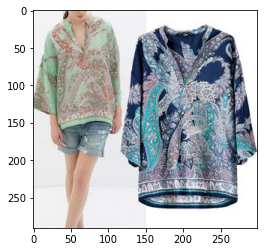

In [5]:
# 画像を１枚，表示してみる
from PIL import Image
import matplotlib.pyplot  as plt

path = X[0] # image_parent_dir + df['Image'].iloc[0] + ".jpg"

img = Image.open(path)
print("Format:", img.format)
print("Mode:", img.mode)
print("Size:", img.size)

plt.imshow(img)

In [12]:
# (参考) クラス番号の最小値と最大値をチェック
import collections
c = collections.Counter(y)
print(min(c.keys())) # 1
print(max(c.keys())) # 48

37
48


In [13]:
# クラス番号が 1 から始まっているため，ゼロオリジンへ調整する
import numpy as np
y = np.array(y) - min(y)

In [23]:
# (参考) 全画像のモードおよびサイズをチェック
# 画像数が多いため、それなりに時間を要する
# → モードは "RGB" のみ／サイズはバラバラ
from PIL import Image

image_sizes = list()
image_modes = list()

for path in X:
    im = Image.open(path)
    image_sizes.append(im.size)
    image_modes.append(im.mode)
    im.close()

print(set(image_modes))
print(set(image_sizes))

{'RGB'}
{(277, 277), (204, 293), (183, 270), (216, 267), (300, 117), (239, 250), (299, 301), (200, 179), (249, 300), (220, 273), (181, 165), (186, 280), (225, 208), (243, 256), (75, 300), (116, 301), (190, 250), (236, 217), (182, 246), (194, 220), (300, 238), (200, 300), (131, 200), (182, 282), (155, 185), (67, 301), (141, 250), (301, 239), (279, 300), (300, 94), (158, 190), (274, 221), (146, 301), (280, 301), (200, 192), (300, 130), (191, 223), (224, 220), (184, 184), (230, 300), (161, 200), (225, 221), (171, 250), (217, 217), (43, 64), (175, 220), (147, 301), (300, 251), (301, 216), (112, 200), (97, 300), (231, 300), (250, 250), (115, 205), (108, 166), (120, 140), (174, 260), (207, 208), (300, 107), (200, 169), (251, 251), (58, 85), (208, 289), (260, 299), (220, 263), (207, 293), (177, 301), (205, 220), (119, 180), (225, 198), (170, 262), (284, 284), (171, 227), (236, 207), (142, 200), (127, 300), (261, 300), (300, 228), (301, 193), (200, 290), (273, 274), (204, 260), (250, 227), (17

In [14]:
# 学習／テストへのデータセット分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("学習データ：{}件".format(len(X_train)))
print("テストデータ：{}件".format(len(X_test)))

学習データ：72440件
テストデータ：18110件


In [15]:
# Dataset クラスの定義
import numpy as np
from PIL import Image
from pathlib import Path
import torch
# import torch.utils.data as data
from torchvision import transforms

# Transformer の定義
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Grayscale(num_output_channels=3), # ResNet 等に喰わせるため，あえて３チャネル
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset : データソースから1個ずつデータを取り出すクラス
# 実装が必要なメソッドは__getitem__と__len__の2つ
# https://ohke.hateblo.jp/entry/2019/12/28/230000

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None): #, input_size):
        super().__init__()
        
        self.transform = transform
        self.image_paths = image_paths
        self.labels = labels
        self.len = len(self.image_paths)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        # 入力
        image = Image.open(image_path)
        
        # covert RGBA to RGB
        # Oxford-III Pet Dataset に少数ながら 'RGBA' が含まれるため，
        # これを RGB へ変換する
        '''
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        '''
        
        if self.transform:
            image = self.transform(image)
        else:
            image = np.asarray(image)
            image = torch.from_numpy(image)
                
        return image, label

train_dataset = MyDataset(X_train, y_train, transform=transform) #, (224, 224))
test_dataset = MyDataset(X_test, y_test, transform=transform) #, (224, 224))

# 動作チェック
image, label = train_dataset[0]
print(image.size(), label)  # torch.Size([3, 256, 256]) 1
print(type(image))
print(type(label))

torch.Size([3, 224, 224]) 4
<class 'torch.Tensor'>
<class 'numpy.int64'>


In [16]:
# DataLoader の定義

BATCH_SIZE = 32 # 16

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, drop_last=True
)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, drop_last=True
)

# 動作チェック
images, labels = next(iter(trainloader))
print(images.size())  # torch.Size([16, 3, 224, 224])
print(labels.size())  # torch.Size([16])

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [17]:
# モデル / optimizer / criterion の定義

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

# GPUあれば使う
def check_cuda():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(check_cuda()) # "cuda"

import sys
print("device: {}".format(device), file=sys.stderr)

num_classes = 48 # 37 # クラス数

# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True) #ResNet
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True) #ResNet

# ResNet18
net = models.resnet18(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, num_classes)

# ResNet50
'''
net = models.resnet50(pretrained=True)
num_features = net.fc.in_features
net.fc = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG16
'''
net = models.vgg16(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# VGG19
'''
net = models.vgg19(pretrained=True)
num_features = net.classifier[6].in_features # in_features = 4096
net.classifier[6] = torch.nn.Linear(num_features, 3) # 3 : number of class (normal, pneumonia, COVID-19)
'''

# Inception v3
# aux_logits の扱いについて：
# https://discuss.pytorch.org/t/error-in-training-inception-v3/23933/7
'''
num_classes = 3 # 3 : number of class (normal, pneumonia, COVID-19)
net = models.inception_v3(pretrained=True, aux_logits=False)
#num_ftrs = net.AuxLogits.fc.in_features
#net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
num_features = net.fc.in_features # in_features = 2048
net.fc = torch.nn.Linear(num_features, num_classes)
'''

# SqueezeNet 1.1
'''
num_classes = 3 # 3 : number of class
net = models.squeezenet1_1(pretrained=True)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
net.num_classes = num_classes
'''

net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.005)

print(net)

device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# 学習
# https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

from tqdm import tqdm

EPOCH = 30

train_loss_value=[]      #trainingのlossを保持するlist
train_acc_value=[]       #trainingのaccuracyを保持するlist
test_loss_value=[]       #tes%MCEPASTEBIN%tのlossを保持するlist
test_acc_value=[]        #testのaccuracyを保持するlist 

for epoch in range(EPOCH):
    print('epoch', epoch+1)    #epoch数の出力

    # 学習
    net.train() # 学習モード
    for (inputs, labels) in tqdm(trainloader):
        # print("inputs", inputs.shape)
        # print("labels", labels.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    #train dataを使ってテストをする(パラメータ更新がないようになっている)
    sum_loss = 0.0          #lossの合計
    sum_correct = 0         #正解率の合計
    sum_total = 0           #dataの数の合計
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    net.eval() # 評価モード
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()                            #lossを足していく
        _, predicted = outputs.max(1)                      #出力の最大値の添字(予想位置)を取得
        sum_total += labels.size(0)                        #labelの数を足していくことでデータの総和を取る
        sum_correct += (predicted == labels).sum().item()  #予想位置と実際の正解を比べ,正解している数だけ足す
    print("train mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)))  #lossとaccuracy出力
    train_loss_value.append(sum_loss*BATCH_SIZE/len(trainloader.dataset))  #traindataのlossをグラフ描画のためにlistに保持
    train_acc_value.append(float(sum_correct/sum_total))   #traindataのaccuracyをグラフ描画のためにlistに保持

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print('epoch{}'.format(epoch+1), file=fp)
        print("train  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(trainloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''
        
    #test dataを使ってテストをする
    sum_loss = 0.0
    sum_correct = 0
    sum_total = 0

    cm_predicted_list = [] # confusion matrix で利用するため予測値を蓄える
    cm_true_list = [] # confusion matrix で利用するため真値を蓄える
    
    net.eval() # 評価モード
    for (inputs, labels) in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predicted = outputs.max(1)
        sum_total += labels.size(0)
        sum_correct += (predicted == labels).sum().item()
        
        # confusion matrix のため予測値／真値を蓄える
        cm_predicted_list += predicted.tolist()
        cm_true_list += labels.tolist()
    print("test  mean loss={}, accuracy={}"
            .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)))
    test_loss_value.append(sum_loss*BATCH_SIZE/len(testloader.dataset))
    test_acc_value.append(float(sum_correct/sum_total))

    '''
    with open("/home/muto/Dropbox/20201230.txt", 'a') as fp:
        print("test  mean loss={}, accuracy={}"
              .format(sum_loss*BATCH_SIZE/len(testloader.dataset), float(sum_correct/sum_total)), file=fp)
    '''

epoch 1


100%|███████████████████████████████████████| 2263/2263 [09:22<00:00,  4.02it/s]


train mean loss=0.514504351160396, accuracy=0.8382539770216527
test  mean loss=0.548487186537205, accuracy=0.8271017699115044
epoch 2


100%|███████████████████████████████████████| 2263/2263 [02:42<00:00, 13.91it/s]


train mean loss=0.4398831453657756, accuracy=0.8659136102518781
test  mean loss=0.47741995491025724, accuracy=0.85625
epoch 3


100%|███████████████████████████████████████| 2263/2263 [02:44<00:00, 13.75it/s]


train mean loss=0.3967231783038802, accuracy=0.8790598762704375
test  mean loss=0.4420559422078546, accuracy=0.8672566371681416
epoch 4


100%|███████████████████████████████████████| 2263/2263 [02:44<00:00, 13.72it/s]


train mean loss=0.3687357565864287, accuracy=0.8886986301369864
test  mean loss=0.4231292267388102, accuracy=0.8725110619469026
epoch 5


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.71it/s]


train mean loss=0.3444496590103121, accuracy=0.8965698188245692
test  mean loss=0.4098345812745413, accuracy=0.8767699115044247
epoch 6


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.32235422253872004, accuracy=0.9040543526292532
test  mean loss=0.40129775083374414, accuracy=0.8797566371681416
epoch 7


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.71it/s]


train mean loss=0.3027091164324969, accuracy=0.9093570481661511
test  mean loss=0.3949928109254842, accuracy=0.8836283185840708
epoch 8


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.71it/s]


train mean loss=0.2828250298030728, accuracy=0.9157506628369421
test  mean loss=0.3922152556548916, accuracy=0.8843473451327434
epoch 9


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.64it/s]


train mean loss=0.2659879322821498, accuracy=0.9223790322580645
test  mean loss=0.3919477719091566, accuracy=0.8843473451327434
epoch 10


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.24787031661930958, accuracy=0.9286207467962881
test  mean loss=0.39366267630568136, accuracy=0.8861172566371681
epoch 11


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.2252847155900636, accuracy=0.9341029606716748
test  mean loss=0.39289054963418885, accuracy=0.8873893805309735
epoch 12


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.2028928162592804, accuracy=0.9413665488289881
test  mean loss=0.39600823973503513, accuracy=0.888108407079646
epoch 13


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.70it/s]


train mean loss=0.18043397707398723, accuracy=0.9476220724701724
test  mean loss=0.40466493730845204, accuracy=0.8879424778761061
epoch 14


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.163939365004881, accuracy=0.9543471056120194
test  mean loss=0.4132112489425958, accuracy=0.8872787610619469
epoch 15


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.70it/s]


train mean loss=0.141887353789339, accuracy=0.9611688024745912
test  mean loss=0.420598382076988, accuracy=0.8839048672566372
epoch 16


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.70it/s]


train mean loss=0.1228238640228633, accuracy=0.967659080866107
test  mean loss=0.43813193702750414, accuracy=0.8824115044247788
epoch 17


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.69it/s]


train mean loss=0.10038196235496093, accuracy=0.9727822580645161
test  mean loss=0.4553391026140642, accuracy=0.8849557522123894
epoch 18


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.68it/s]


train mean loss=0.08745576339176779, accuracy=0.9779054352629253
test  mean loss=0.4759005621939585, accuracy=0.8782632743362832
epoch 19


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.68it/s]


train mean loss=0.07442998800165478, accuracy=0.9815510384445426
test  mean loss=0.49372590690077767, accuracy=0.8805862831858408
epoch 20


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.68it/s]


train mean loss=0.06066010752121991, accuracy=0.9835671674768007
test  mean loss=0.5116878538682011, accuracy=0.8798672566371681
epoch 21


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.67it/s]


train mean loss=0.05368394157517555, accuracy=0.9875718073353955
test  mean loss=0.5249042896425309, accuracy=0.8776548672566372
epoch 22


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.68it/s]


train mean loss=0.04282529716051329, accuracy=0.9906788555015467
test  mean loss=0.5501742773132388, accuracy=0.8787057522123893
epoch 23


100%|███████████████████████████████████████| 2263/2263 [02:49<00:00, 13.32it/s]


train mean loss=0.039180089461487065, accuracy=0.9916454927087937
test  mean loss=0.5566247128587872, accuracy=0.8751106194690266
epoch 24


100%|███████████████████████████████████████| 2263/2263 [02:46<00:00, 13.56it/s]


train mean loss=0.03253636920257934, accuracy=0.9933992487847989
test  mean loss=0.575107939186707, accuracy=0.8754424778761062
epoch 25


100%|███████████████████████████████████████| 2263/2263 [02:46<00:00, 13.63it/s]


train mean loss=0.02812634103816807, accuracy=0.9941035130357931
test  mean loss=0.5880679812782184, accuracy=0.8755530973451328
epoch 26


100%|███████████████████████████████████████| 2263/2263 [02:46<00:00, 13.62it/s]


train mean loss=0.023966349565955253, accuracy=0.9953463323022537
test  mean loss=0.6007866156802264, accuracy=0.8765486725663717
epoch 27


100%|███████████████████████████████████████| 2263/2263 [02:46<00:00, 13.62it/s]


train mean loss=0.020546890225020778, accuracy=0.9958434600088378
test  mean loss=0.6158138411207005, accuracy=0.879646017699115
epoch 28


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.63it/s]


train mean loss=0.019129826270469656, accuracy=0.9963682059213433
test  mean loss=0.6217189644858825, accuracy=0.8758849557522124
epoch 29


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.64it/s]


train mean loss=0.017132250933683195, accuracy=0.9965753424657534
test  mean loss=0.620508824182702, accuracy=0.875
epoch 30


100%|███████████████████████████████████████| 2263/2263 [02:45<00:00, 13.66it/s]


train mean loss=0.015322173441837896, accuracy=0.9968377154220062
test  mean loss=0.6431479975745732, accuracy=0.8777654867256637


Matplotlib is building the font cache; this may take a moment.


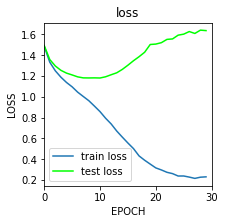

In [8]:
# 損失の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_loss_value)
plt.plot(range(EPOCH), test_loss_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 2.5)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.savefig("loss_image.png")

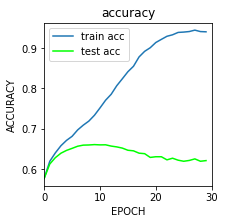

In [9]:
# 正解率の可視化
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))

plt.plot(range(EPOCH), train_acc_value)
plt.plot(range(EPOCH), test_acc_value, c='#00ff00')
plt.xlim(0, EPOCH)
# plt.ylim(0, 1)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.savefig("accuracy_image.png")

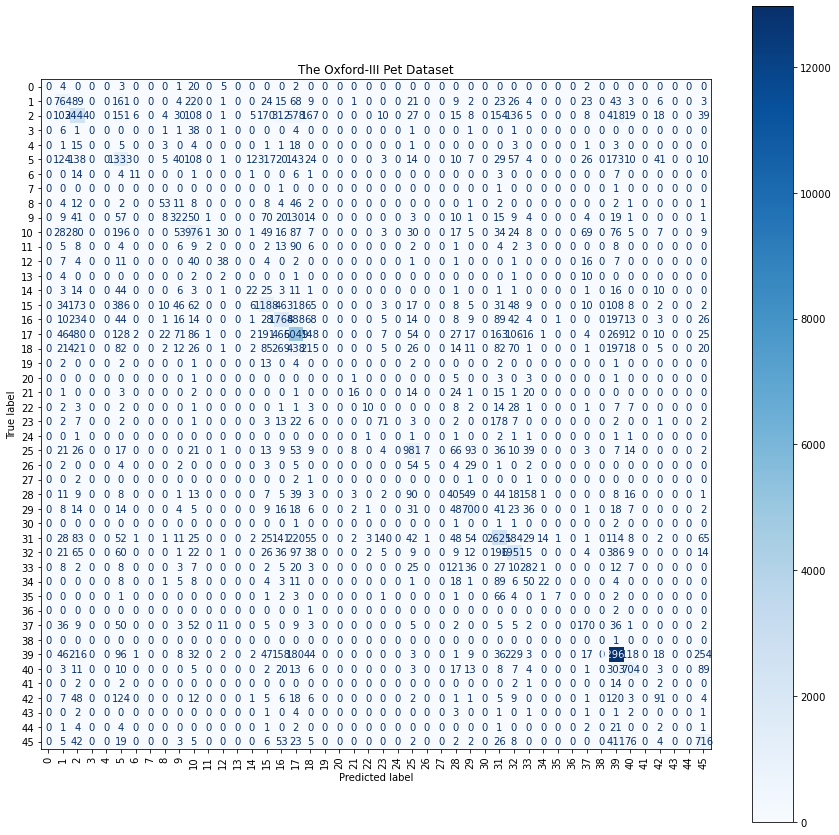

In [12]:
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
The Oxford-III Pet Dataset
cm = confusion_matrix(cm_true_list, cm_predicted_list)
cmp = ConfusionMatrixDisplay(cm) # , display_labels=class_names)

fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Deep Fashion: Category Prediction')
cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)